In [1]:
from __future__ import print_function, division

import os
import operator
import functools
import time
import glob
import tables as tb
import pandas as pd
print("Running on ", time.asctime())

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import invisible_cities.database.load_db as DB
import invisible_cities.core.system_of_units_c as SystemOfUnits
import invisible_cities.reco.pmaps_functions as pmapf
import invisible_cities.core.fit_functions as fitf

DataPMT = DB.DataPMT()
DataSiPM = DB.DataSiPM()
units = SystemOfUnits.SystemOfUnits()
pi = np.pi


Running on  Tue Apr 18 19:42:06 2017


#### General plotting options

In [2]:
plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

outputfolder = "plots/Na_3575/Cuts_S1h_S1w_S2i"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

#### Usefull functions

In [3]:
def width(times, to_mus=False):
    """
    Compute peak width.
    """
    w = (np.max(times) - np.min(times)) if np.any(times) else 0.
    return w * units.ns/units.mus if to_mus else w


def timefunc(f):
    """
    Decorator for function timing.
    """
    def time_f(*args, **kwargs):
        t0 = time.time()
        output = f(*args, **kwargs)
        print("Time spent in {}: {} s".format(f.__name__,
                                              time.time() - t0))
        return output
    return time_f


def integrate_charge(d):
    """
    Integrate charge from a SiPM dictionary.
    """
    newd = dict((key, np.sum(value)) for key, value in d.items())
    return map(np.array, list(zip(*newd.items())))


def flat(nested_list):
    while hasattr(nested_list[0], "__iter__"):
        nested_list = [item for inner_list in nested_list for item in inner_list]
    return np.array(nested_list)


def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def save_to_folder(outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)



def get_centers(xbins):
    # xbins should be shifted, as it contains the lower bounds
    # and we want bin centers
    return xbins[:-1] + np.diff(xbins) * 0.5


def profile_and_scatter(x, y, z, nbin, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, *args, **kwargs)
    x_ = np.repeat(x, x.size)
    y_ = np.tile  (y, y.size)
    z_ = z.flatten()
    return (x, y, z, ze), plt.scatter(x_, y_, c=z_, marker="s"), plt.colorbar()

save = functools.partial(save_to_folder, outputfolder)

### Input data

In [4]:
# Comment out this line if your data is in $IC_DATA
os.environ["IC_DATA"] = "/home/brais/Documents/Next/Na/data/3575_DST/"

pattern = "$IC_DATA/run*.dst"
ifiles  = glob.glob(os.path.expandvars(pattern))
print("# files:", len(ifiles))

# files: 1


### Reading data

In [5]:
def load_dst(filename, group, node):
    with tb.open_file(filename) as h5in:
        table = getattr(getattr(h5in.root, group), node).read()
        return pd.DataFrame.from_records(table)

In [6]:
data_read = load_dst(ifiles[0], "DST", "KrEvents")

In [7]:
data_read

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,2,1.491342e+09,0,1,300.0,64.295494,368.761440,486125.0,41.665438,9505.395508,...,654462.5,49,168.3375,168.3375,-30.902690,53.909130,62.138318,2.091304,41.113927,58.683844
1,4,1.491342e+09,0,1,200.0,36.470367,194.114036,531950.0,23.402500,9115.522461,...,661462.5,27,129.5125,129.5125,57.252296,0.689844,57.256452,0.012049,12.112382,52.490100
2,6,1.491342e+09,0,1,275.0,49.535275,280.593985,504150.0,30.916812,9145.306641,...,665462.5,43,161.3125,161.3125,-80.515359,8.131453,80.924926,3.040941,20.215411,13.245800
3,8,1.491342e+09,0,1,225.0,35.185417,198.563369,517600.0,29.096375,9989.318359,...,654862.5,22,137.2625,137.2625,72.665855,68.384014,99.783264,0.755051,13.088289,22.880939
4,10,1.491342e+09,0,1,175.0,25.911135,124.800847,485300.0,11.868625,10998.766602,...,655862.5,26,170.5625,170.5625,-123.266410,13.225686,123.973895,3.034708,11.965158,10.286520
5,12,1.491342e+09,0,1,225.0,34.424568,189.214580,617450.0,39.079687,20055.962891,...,656412.5,50,38.9625,38.9625,79.846011,-0.266283,79.846455,-0.003335,12.658441,19.831387
6,14,1.491342e+09,0,1,250.0,43.252735,236.096375,541050.0,68.862500,13995.712891,...,655512.5,34,114.4625,114.4625,-174.992367,15.988061,175.721218,3.050481,13.079184,12.064809
7,16,1.491342e+09,0,1,175.0,19.324360,99.215133,628650.0,13.012500,13123.942383,...,657487.5,31,28.8375,28.8375,175.699925,85.071095,195.211565,0.450915,10.204540,11.866561
8,18,1.491342e+09,0,1,225.0,22.561430,120.893649,485025.0,13.671250,9307.364258,...,657037.5,24,172.0125,172.0125,56.364348,-5.646193,56.646440,-0.099840,11.839712,11.626397
9,1,1.491342e+09,0,1,250.0,37.180885,213.993739,465200.0,25.764250,5534.005859,...,667062.5,27,201.8625,201.8625,-21.716178,4.069103,22.094117,2.956364,16.455187,11.912408



### Filtering data

In [8]:
from copy import deepcopy
from functools import reduce

def Filter(data):
    filtered_XR = deepcopy(data)
    filtered_noXR = deepcopy(data)
    
    min_S1w = 250.
    max_S1w = 400.
    min_S1h = 10.
    max_S1h = 100.
    
    min_S2e = 1000.
    max_S2e = 12000.
    
    print('Inicial: ',len(filtered_XR), len(filtered_noXR))
    
    filtered_XR = filtered_XR[filtered_XR.S2e>min_S2e]
    filtered_XR = filtered_XR[filtered_XR.S2e<max_S2e]
    
    
    print('S2 XR Energy: ', len(filtered_XR))
    
    filtered_XR = filtered_XR[filtered_XR.Nsipm>0]
    
    print('Nsimp > 0: ', len(filtered_XR))
    
    
    #filtered_noXR = filtered_noXR[filtered_noXR.S2e<min_S2e]
    filtered_noXR = filtered_noXR[filtered_noXR.S2e>max_S2e]
    
    print('no XR: ', len(filtered_noXR))
    
    return filtered_XR, filtered_noXR


In [9]:
filt_XR, filt_noXR = Filter(data_read)

Inicial:  28907 28907
S2 XR Energy:  2164
Nsimp > 0:  2164
no XR:  26743


In [ ]:
dataread

### S1 and S2 propierties

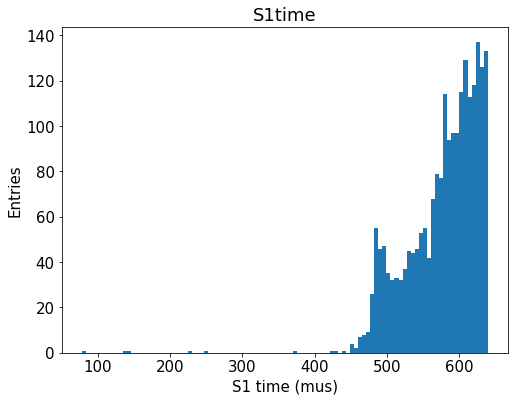

In [10]:
s1t = filt_XR.S1t/1e3

hist(s1t, 100)
labels("S1 time (mus)", "Entries")
save("S1time")

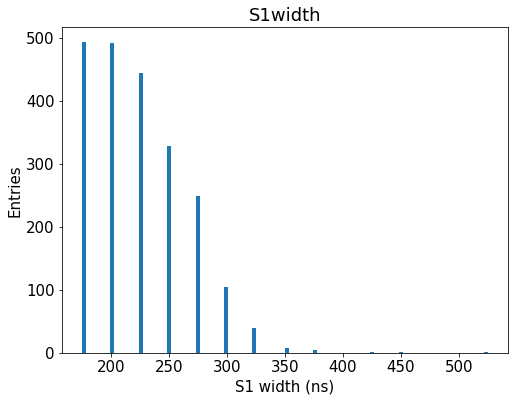

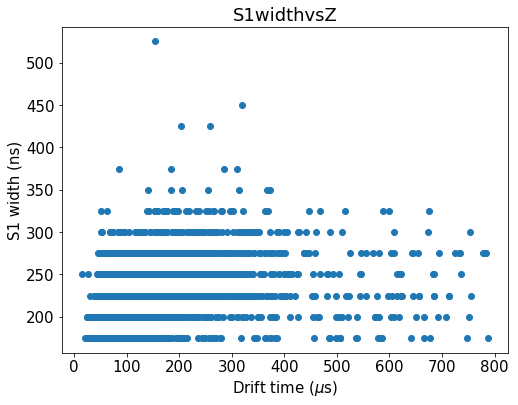

In [11]:
s1w = filt_XR.S1w

################################
hist(s1w, 100)#, range=(0, 900))
labels("S1 width (ns)", "Entries")
save("S1width")

################################

scatter(filt_XR.Z, s1w)
#x, y, _ = fitf.profileX(filt_XR.Z, s1w, 50)
#plt.plot(x, y, profOpt)
#f = fitf.fit(fitf.polynom, x, y, (1., 1.))
#plt.plot(x, f.fn(x), fitOpt)
#plt.text(20, 20, "{:.3f} + {:.3f} x".format(*f.values))
labels("Drift time ($\mu$s)", "S1 width (ns)")

save("S1widthvsZ")

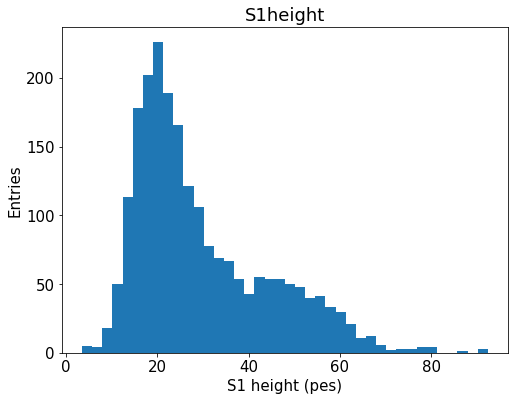

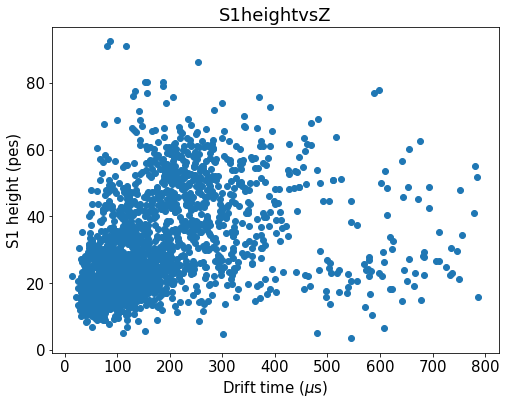

In [12]:
s1h = filt_XR.S1h


################################
hist(s1h, 40)
#plt.semilogy()
labels("S1 height (pes)", "Entries")
save("S1height")

################################

scatter(filt_XR.Z, s1h)
#x, y, _ = fitf.profileX(data.Z[:,0], s1h, 100)
#plt.plot(x, y, profOpt)
#f = fitf.fit(fitf.polynom, x, y, (1., 0.8, 0.01))
#plt.plot(x, f.fn(x), fitOpt)
#plt.text(0, 6, "{:.3g} + {:.3g} x + {:.3g} x^2".format(*f.values))
labels("Drift time ($\mu$s)", "S1 height (pes)")
#plt.ylim(0, 100)
save("S1heightvsZ")


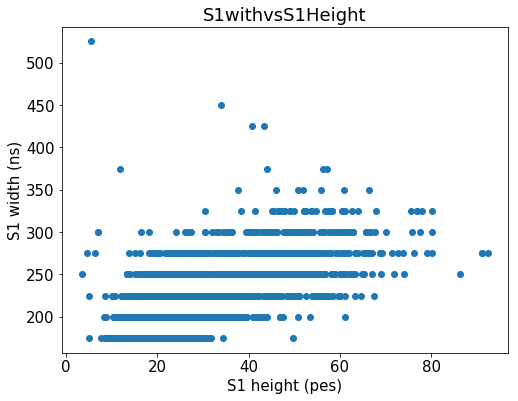

In [13]:
s1h = filt_XR.S1h
s1w = filt_XR.S1w

scatter(s1h,s1w)
plt.yscale
#x, y, _ = fitf.profileX(s1h, s1w, 100)
#plt.plot(x, y, profOpt)
#f = fitf.fit(fitf.polynom, x, y, (1., 1e-2, 1e-4))
#plt.plot(x, f.fn(x), fitOpt)
#plt.text(0, 100, "{:.3g} + {:.3g} x + {:.3g} x^2".format(*f.values))
labels("S1 height (pes)", "S1 width (ns)")
#plt.xlim(0, 100)
save("S1withvsS1Height")

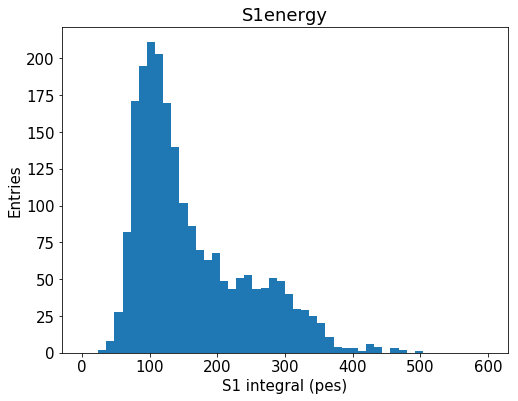

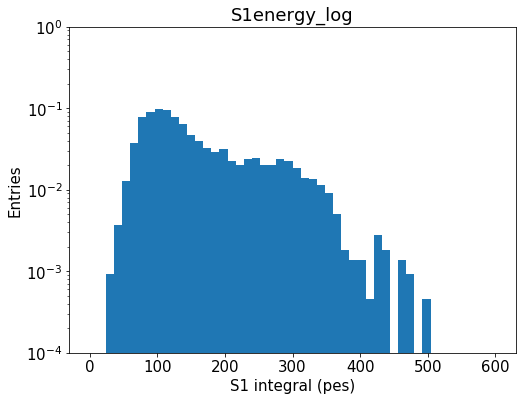

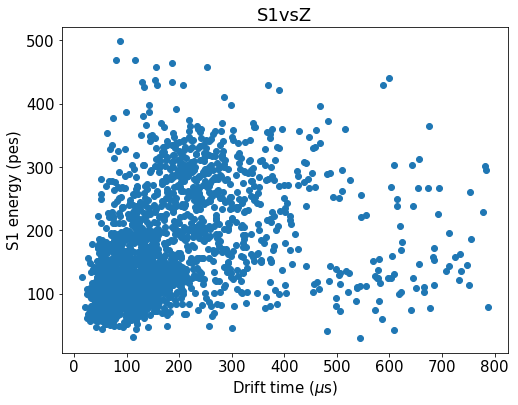

In [14]:
s1e = filt_XR.S1e

################################
hist(s1e, 50, range=(0, 600))
labels("S1 integral (pes)", "Entries")
save("S1energy")

################################
pdf(s1e, 50, range=(0, 600))
labels("S1 integral (pes)", "Entries")
save("S1energy_log")

################################

scatter(filt_XR.Z, s1e)

labels("Drift time ($\mu$s)", "S1 energy (pes)")

save("S1vsZ")


/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))
/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


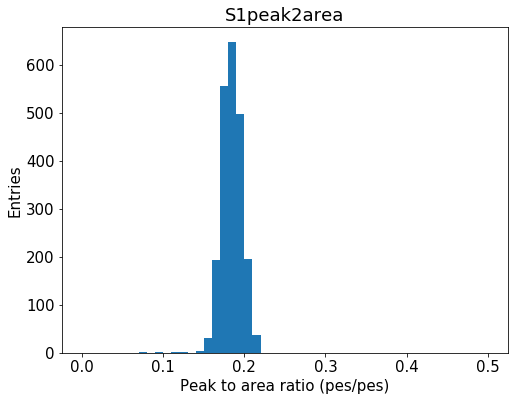

In [15]:
################################
y, x, _ = hist(s1h/s1e, 50, range=(0, 0.5))
x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 0.3, 0.01))
#plt.plot(x, f.fn(x), "r")
labels("Peak to area ratio (pes/pes)", "Entries")
save("S1peak2area")

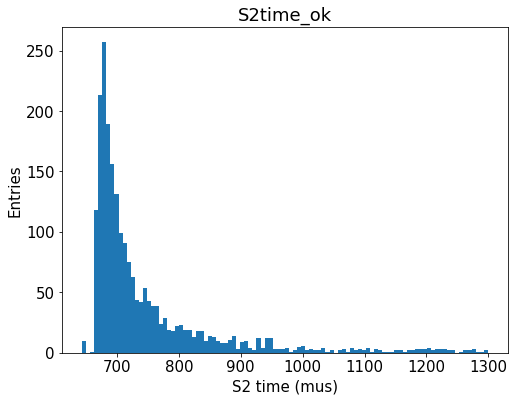

In [16]:
s2t =filt_XR.S2t/1e3

################################
hist(s2t, 100)#, range=(0, 10e2))
labels("S2 time (mus)", "Entries")
save("S2time_ok")

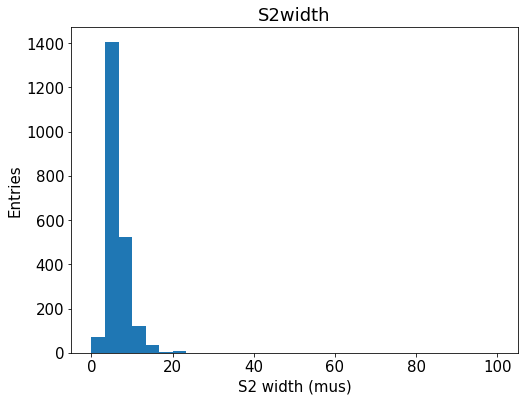

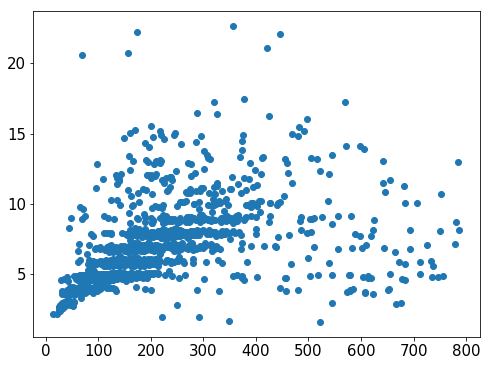

In [17]:
s2w = filt_XR.S2w

################################
hist(s2w, 30, range=(0, 100))
labels("S2 width (mus)", "Entries")
save("S2width")

################################
scatter(filt_XR.Z, s2w)
#x, y, _ = fitf.profileX(data.Z, s2w, 100)
#plt.plot(x, y, profOpt)
#f = fitf.fit(fitf.power, x, y, (1., 0.8))
#plt.plot(x, f.fn(x), fitOpt)
#plt.text(0, 20, "{:.3f} $\cdot$ x^{:.2f}".format(*f.values))
#labels("Drift time ($\mu$s)", "S2 width ($\mu$s)")
#plt.ylim(0, 30)
#save("S2widthvsZ")

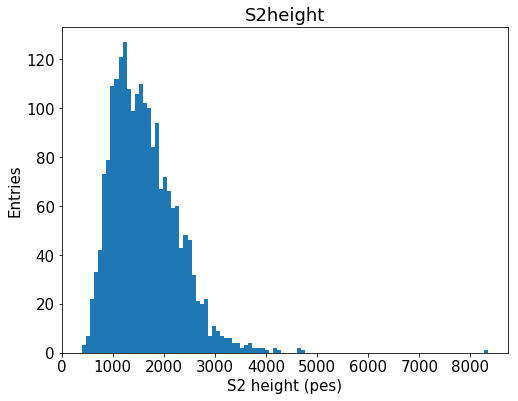

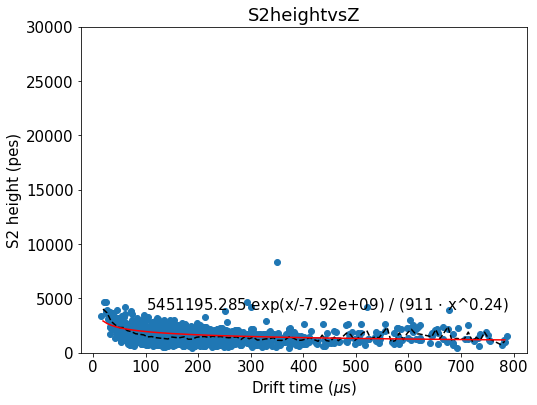

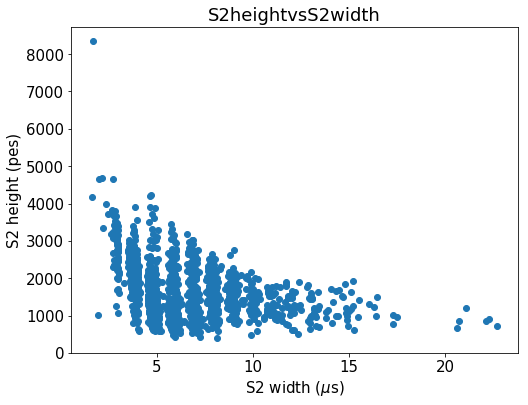

In [18]:
s2h = filt_XR.S2h

################################
hist(s2h, 100)#, range=(0, 15e3))
labels("S2 height (pes)", "Entries")
save("S2height")

################################
scatter(filt_XR.Z, s2h)
x, y, _ = fitf.profileX(filt_XR.Z, s2h, 100)
plt.plot(x, y, profOpt)
fun = lambda x, *args: fitf.expo(x,*args[:2])/fitf.power(x, *args[2:])
f = fitf.fit(fun, x, y, (1., -2e4, 0.1, -0.8))
plt.plot(x, f.fn(x), fitOpt)
plt.text(1e2, 4e3, "{:.3f} exp(x/{:.3g}) / "
                   "({:.3g} $\cdot$ x^{:.2f})".format(*f.values))
labels("Drift time ($\mu$s)", "S2 height (pes)")
plt.ylim(0, 3e4)
save("S2heightvsZ")

################################
scatter(s2w, s2h)
#x, y, _ = fitf.profileX(s2w, s2h, 50)
#plt.plot(x, y, profOpt)
#f = fitf.fit(fitf.power, x, y, (1., -1.0))
#plt.plot(x, f.fn(x), fitOpt)
#plt.text(10, 4e3, "{:.3f} $\cdot$ x^{:.2f}".format(*f.values))
labels("S2 width ($\mu$s)", "S2 height (pes)")
#plt.ylim(0, 3e4)
#plt.xlim(0,100)
save("S2heightvsS2width")

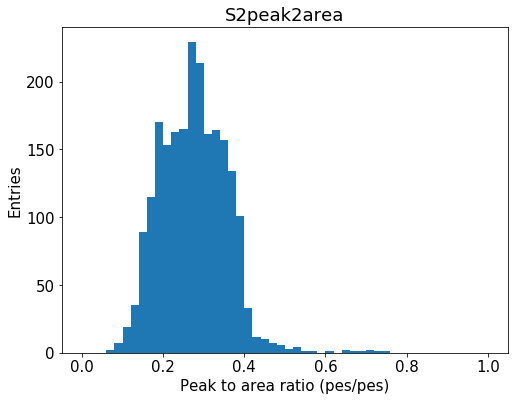

In [21]:
################################
hist(s2h/s2e, 50, range=(0, 1))
labels("Peak to area ratio (pes/pes)", "Entries")
save("S2peak2area")

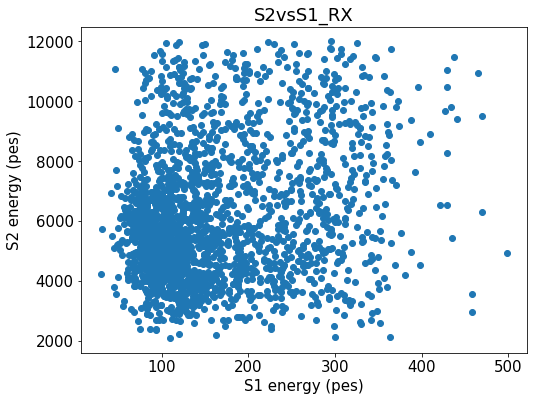

In [22]:
################################
scatter(s1e, s2e)

labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1_RX")

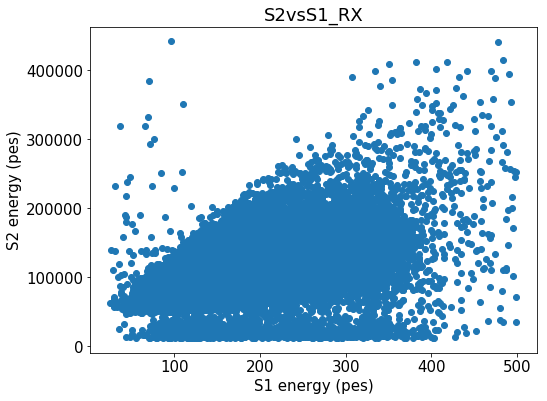

In [23]:
################################
scatter(filt_noXR.S1e, filt_noXR.S2e)

labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1_RX")

### Energy

In [20]:
s2e = filt_XR.S2e

In [24]:
(2.355*1272/4670.),(30/2458)**0.5*(2.355*1272/4670)

(0.6414475374732334, 0.07086484316436774)

/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


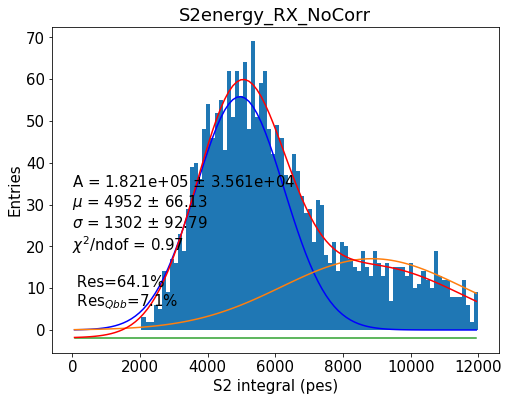

In [25]:
fun = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:-1])+args[-1] 

s2e = filt_XR.S2e
entries, xbins, _ = hist(s2e, 100, range=(0, 12e3))
xbins = get_centers(xbins)


f = fitf.fit(fun, xbins, entries,(100, 5000, 2000, 100, 6000, 2000,10))

text = "\n".join(["{} = {:.4g} $\pm$ {:.4g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res=64.1% \n Res$_{Qbb}$=7.1% "

plt.text(0, 5, text, fontsize=15);
plt.plot(xbins, fitf.gauss(xbins, *f.values[:3]), "b-")
plt.plot(xbins, fitf.gauss(xbins, *f.values[3:-1]))
plt.plot(xbins, f.values[-1]*np.ones_like(xbins))
plt.plot(xbins, f.fn(xbins), fitOpt)


labels("S2 integral (pes)", "Entries")
save("S2energy_RX_NoCorr")

# Z Correction 

[ 8135.43383624  -219.77268762]


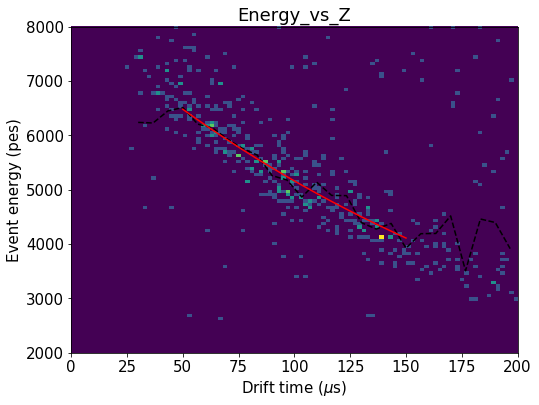

In [26]:
rcut = 100.

xbin, ybin, z, axis = hist2d(filt_XR[filt_XR.R<rcut].Z, filt_XR[filt_XR.R<rcut].S2e, 100, [[0,200], [2000,8000]])
x, y, _ = fitf.profileX(filt_XR.Z[filt_XR.R<rcut], filt_XR.S2e[filt_XR.R<rcut], 30, xrange=[0,200], yrange=[3000,7000])
plt.plot(x, y, profOpt)
sel  = fitf.in_range(x, 50, 155)
x, y = x[sel], y[sel]
f = fitf.fit(fitf.expo, x, y, (1e5, -200))
plt.plot(x, f.fn(x), fitOpt)
print(f.values)
labels("Drift time ($\mu$s)", "Event energy (pes)")
save("Energy_vs_Z")

zfun  = f.fn
zmin  = np.min(x)
zcorr = lambda z: zfun(zmin)/zfun(z)

[  1.02658906e+05   6.19430218e+03   4.51852248e+02   1.34520418e+04
   7.23437638e+03   5.00000000e+02   4.62281215e+00]
res 0.171788849122 0.0189786212265


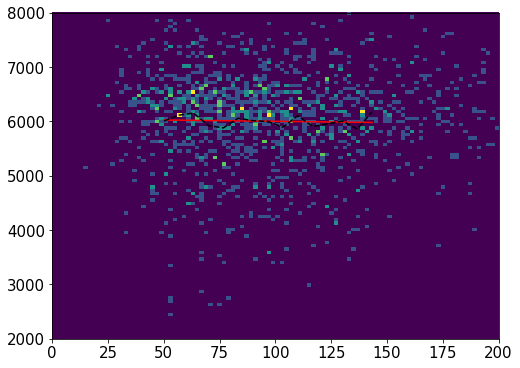

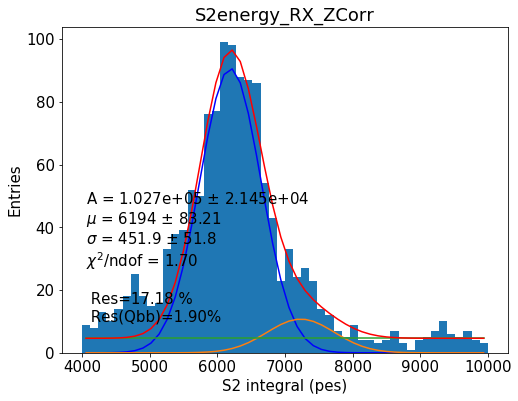

In [27]:
s2e = filt_XR.S2e * zcorr(filt_XR.Z)

xbin, ybin, z, axis = hist2d(filt_XR.Z, s2e, 100, [[0,200], [2000,8000]])
x, y, _ = fitf.profileX(filt_XR.Z, s2e, 30, xrange=[0,200], yrange=[2000,8000])
sel  = fitf.in_range(x, 50, 150)
x, y = x[sel], y[sel]
f = fitf.fit(fitf.expo, x, y, (1e5, -200))
plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, y, profOpt)


entries, xbins, _ = hist(s2e, 50, range=(4e3, 10e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 5500, 12000)


f = fitf.fit(fun, xbins[selbins], entries[selbins],( 9e4, 6500, 500, 9e4, 7050, 500, 10),
                                            bounds=([8e4, 6000, 100, 1e4, 7000, 500, 0],
                                                    [2e5, 7000, 1000,2e5, 7500, 2e4, 30] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.4g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

plt.text(min(xbins), 10, text, fontsize=15);
plt.plot(xbins, fitf.gauss(xbins, *f.values[:3]), "b-")
plt.plot(xbins, fitf.gauss(xbins, *f.values[3:-1]))
plt.plot(xbins, f.values[-1]*np.ones_like(xbins))
plt.plot(xbins, f.fn(xbins), fitOpt)


labels("S2 integral (pes)", "Entries")
save("S2energy_RX_ZCorr")

## R correction

[  5.49833087e+03   2.04914231e+01  -1.22705325e-01]


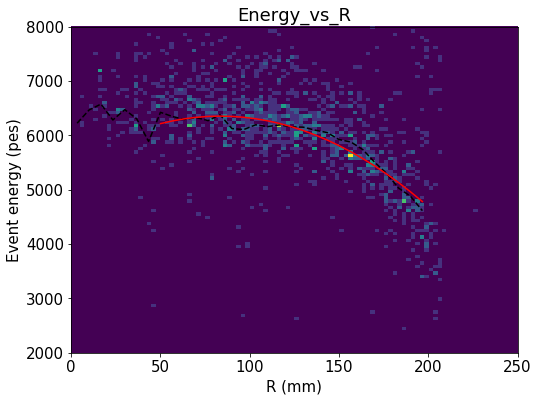

In [28]:
xbin, ybin, z, axis = hist2d(filt_XR.R, s2e, 100, [[0,250], [2000,8000]])
x, y, _ = fitf.profileX(filt_XR.R, s2e, 30, xrange=[0,200], yrange=[3000,7000])
plt.plot(x, y, profOpt)
sel  = fitf.in_range(x, 50, 200)
x, y = x[sel], y[sel]
f = fitf.fit(fitf.polynom, x, y, (6000,-200, -200))
plt.plot(x, f.fn(x), fitOpt)
print(f.values)
labels("R (mm)", "Event energy (pes)")
save("Energy_vs_R")

rfun  = f.fn
rmin  = np.min(x)
rcorr = lambda r: rfun(rmin)/rfun(r)

[  1.04960608e+05   6.21280772e+03   4.00000000e+02   3.99963177e+04
   7.00100000e+03   6.54167930e+02   1.89819257e-22]
res 0.151622268478 0.0167506891027


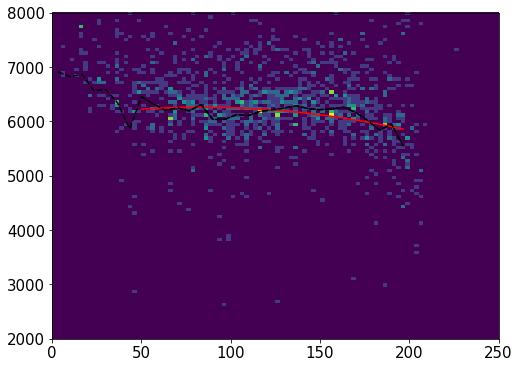

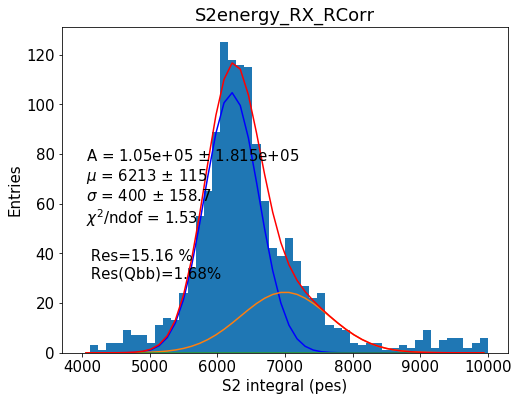

In [29]:
r_s2e = s2e * rcorr(filt_XR.R)

xbin, ybin, z, axis = hist2d(filt_XR.R, r_s2e, 100, [[0,250], [2000,8000]])
x, y, _ = fitf.profileX(filt_XR.R, r_s2e, 30, xrange=[0,200], yrange=[3000,7000])
plt.plot(x, y, profOpt)
sel  = fitf.in_range(x, 50, 200)
x, y = x[sel], y[sel]
f = fitf.fit(fitf.polynom, x, y, (6000,-200, -200))
plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, y, profOpt)


entries, xbins, _ = hist(r_s2e, 50, range=(4e3, 10e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 5.5e3, 8e3)


f = fitf.fit(fun, xbins[selbins], entries[selbins], (4.7e4, 6.250e3, 5.5e2, 1e4, 7000, 500, 10),
                                            bounds=([4.0e4, 6.000e3, 4.0e2, 0.1e4, 7000, 100, 0],
                                                    [5.0e5, 6.500e3, 6.0e2, 6e4, 7001, 5e6, 100] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.4g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

plt.text(min(xbins), 30, text, fontsize=15);
plt.plot(xbins, fitf.gauss(xbins, *f.values[:3]), "b-")
plt.plot(xbins, fitf.gauss(xbins, *f.values[3:-1]))
plt.plot(xbins, f.values[-1]*np.ones_like(xbins))
plt.plot(xbins, f.fn(xbins), fitOpt)


labels("S2 integral (pes)", "Entries")
save("S2energy_RX_RCorr")

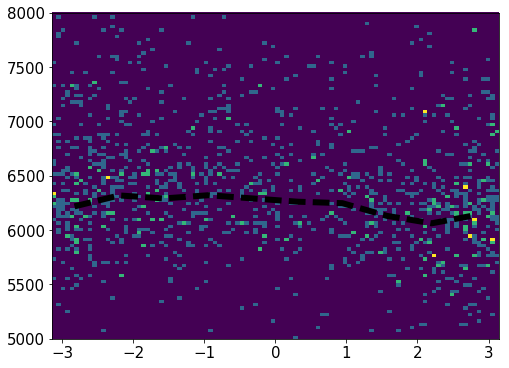

In [30]:
xbin, ybin, z, axis = hist2d(filt_XR.Phi, r_s2e, 100, [[-pi,pi], [5000,8000]])
x, y, _ = fitf.profileX(filt_XR.Phi, r_s2e, 10, xrange=[-pi,pi], yrange=[5000,7000])
plt.plot(x, y, profOpt, linewidth=6)

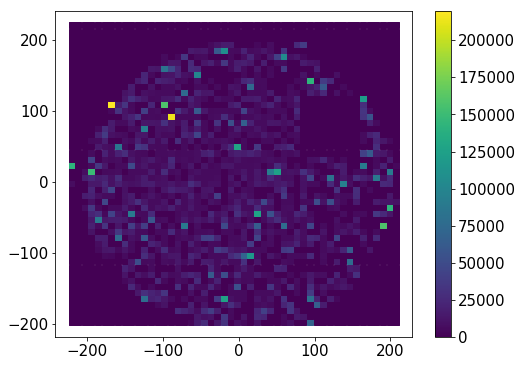

In [37]:
profile_and_scatter(filt_XR.X, filt_XR.Y,r_s2e,[50,50]);

# Full range results

In [32]:
full = data_read[:]

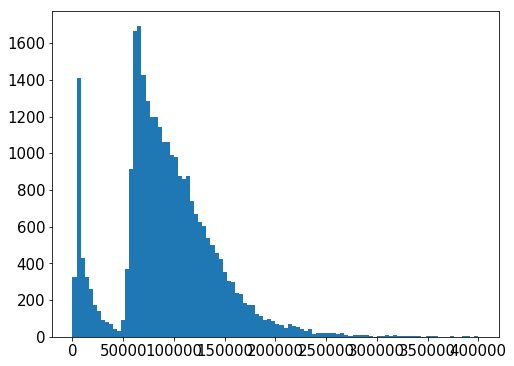

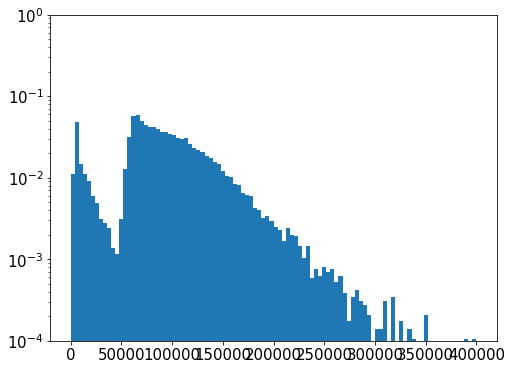

In [33]:
entries, xbins, _ = hist(full.S2e, 100, range=(0,4e5))
Fuya = pdf(full.S2e, 100, range=(0,4e5))

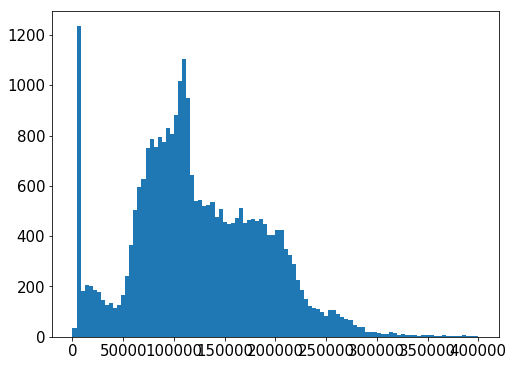

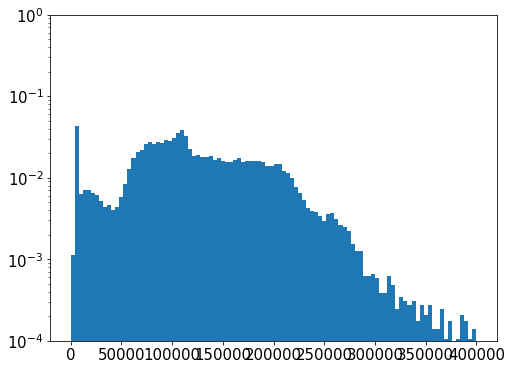

In [34]:
fullE = full.S2e
fullE = fullE * zcorr(full.Z)

entries, xbins, _ = hist(fullE, 100, range=(0,4e5))
a = pdf(fullE, 100, range=(0,4e5))

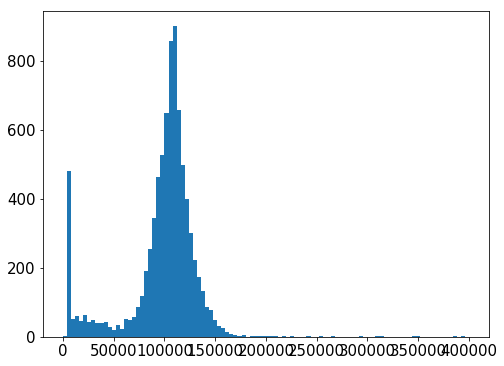

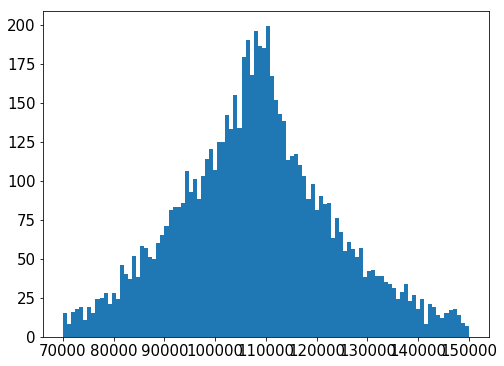

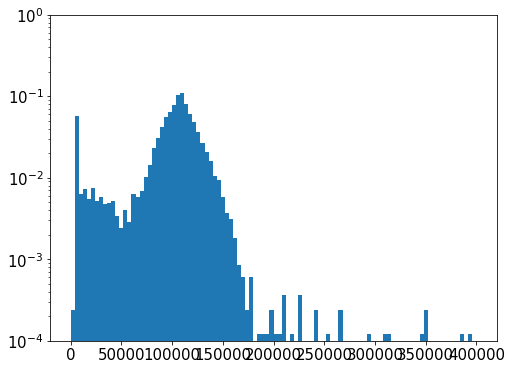

In [35]:
r_fullE = fullE[(full.S1e>100)& (full.S1e<150)] * rcorr(full.R[(full.S1e>100)& (full.S1e<150)])

entries, xbins, _ = hist(r_fullE, 100, range=(0,4e5))

entries, xbins, _ = hist(r_fullE, 100, range=(7e4,1.5e5))
a = pdf(r_fullE, 100, range=(0,4e5))

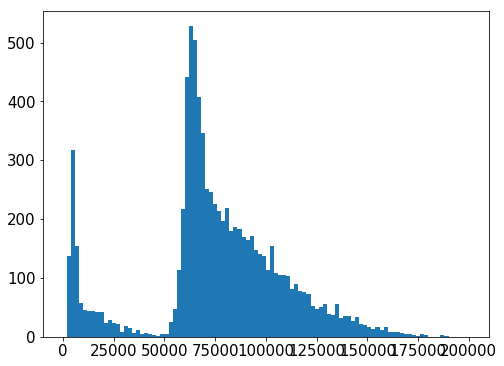

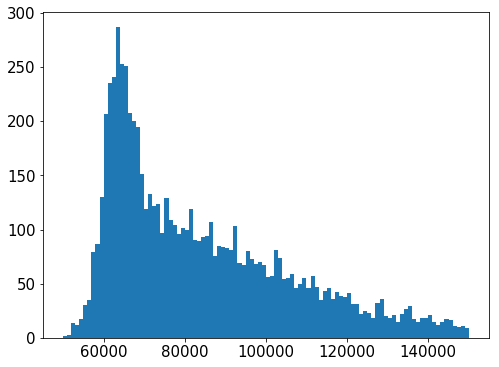

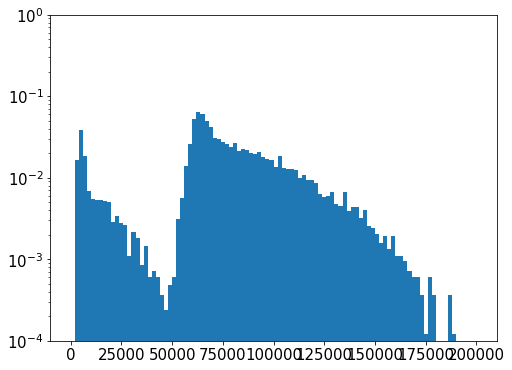

In [36]:
r_fullE = fullE * rcorr(full.R)

entries, xbins, _ = hist(full[(full.S1e>100)& (full.S1e<150)].S2e, 100, range=(0,2e5))

entries, xbins, _ = hist(full[(full.S1e>100)& (full.S1e<150)].S2e, 100, range=(5e4,1.5e5))
a = pdf(full[(full.S1e>100)& (full.S1e<150)].S2e, 100, range=(0,2e5))